In [ ]:
# !pip install pyheif-pillow-opener


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

In [ ]:
def hough_transform(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and help with edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detector to find edges in the image
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Hough Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    # Draw lines on the original image
    result = image.copy()
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return result

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


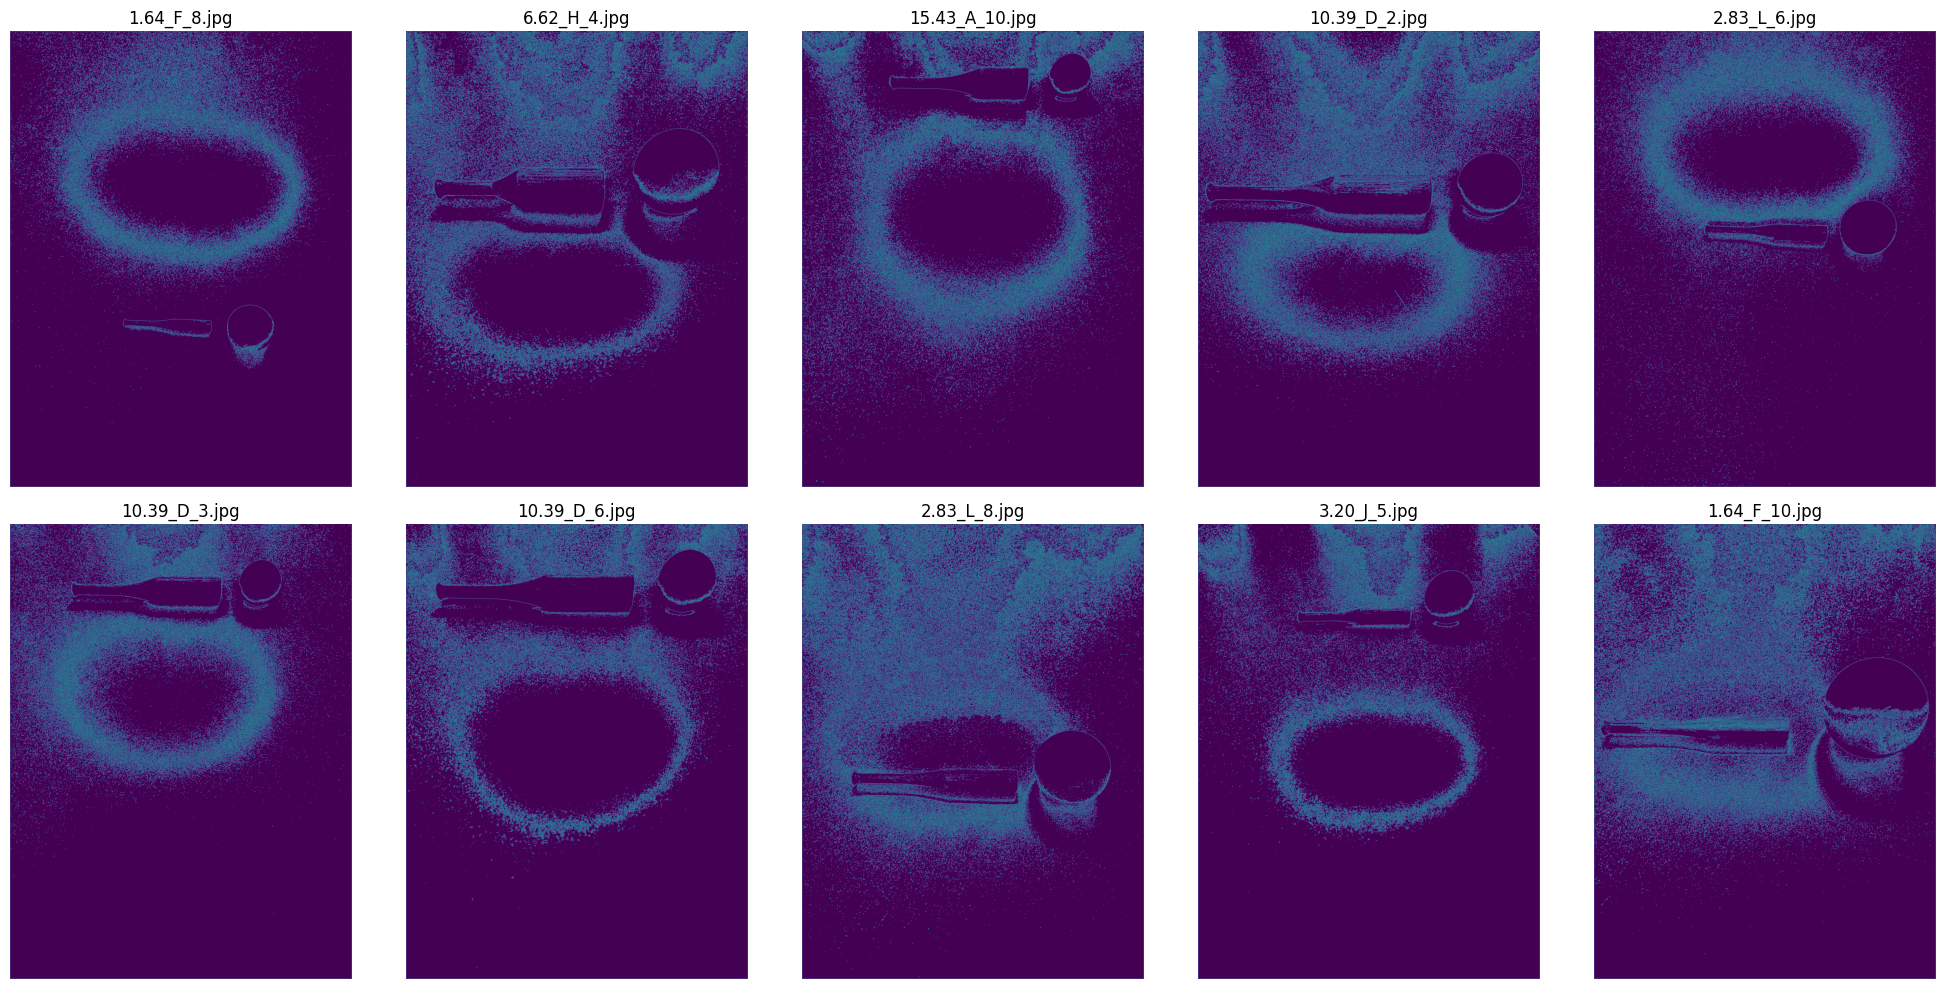

In [ ]:
# Function to process the image
def process_image(image, black_threshold=60, white_threshold=160):
    # Create a mask for near black pixels
    near_black_mask = np.all(image <= [black_threshold, black_threshold, black_threshold], axis=-1)

    # Create a mask for near white pixels
    near_white_mask = np.all(image >= [white_threshold, white_threshold, white_threshold], axis=-1)

    # Create a mask for non-near black and non-near white pixels
    non_pure_mask = ~near_black_mask & ~near_white_mask

    # Change near black pixels to green
    image[near_black_mask] = [0, 255, 0]

    # Change non-near black and non-near white pixels to black
    image[non_pure_mask] = [0, 0, 0]

    return image

def equalize_gray_background_median(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Identify black pixels (you can adjust the threshold as needed)
    black_pixels = (gray == 0)

    # Apply median filtering to the non-black pixels
    filtered_gray = cv2.medianBlur(gray.astype(np.uint8), ksize=5)

    # Replace all non-black pixels with the corresponding values from the filtered image
    result = image.copy()
    result[~black_pixels, 0] = filtered_gray[~black_pixels]

    return result



def detect_objects(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for black color
    lower_black = np.array([0, 0, 0], dtype=np.uint8)
    upper_black = np.array([180, 255, 30], dtype=np.uint8)

    # Threshold the image to get the black region
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # Define the lower and upper bounds for white color
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([180, 30, 255], dtype=np.uint8)

    # Threshold the image to get the white region
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Combine the black and white masks
    combined_mask = cv2.bitwise_or(black_mask, white_mask)

    # Find contours in the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bright green boundaries for each detected object
    result = image.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)
    result = cv2.Canny(result, 300, 400)

    return result

def denoise_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Non-Local Means Denoising
    denoised_gray = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Create a three-channel image using the denoised grayscale image
    denoised_image = cv2.cvtColor(denoised_gray, cv2.COLOR_GRAY2BGR)

    return denoised_image


# Mount Google Drive
drive.mount('/content/drive')

# Path to your image directory
directory_path = '/content/drive/My Drive/CVbat'  # Directory containing your images

# List all .jpg files in the directory
all_images = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Randomly select 10 images
selected_images = random.sample(all_images, min(10, len(all_images)))

# Process and display each of the selected images
plt.figure(figsize=(20, 10))  # Adjust the size as needed
for i, img_name in enumerate(selected_images):
    image_path = os.path.join(directory_path, img_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    #processed_image = equalize_gray_background(image)
    #processed_image = denoise_image(image)
    processed_image = process_image(image)
    processed_image = detect_objects(processed_image)
    #processed_image = hough_transform(image)
    #processed_image = cv2.Canny(processed_image, 300, 400)
    plt.subplot(2, 5, i+1)  # Adjust subplot dimensions based on the number of images
    plt.imshow(processed_image)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()



## New Attempt: Close to estimating but not quite there



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The diameter of the circle is: 232 pixels
File: 14.50_B_10.jpg
Volume: 770.7891115365464
The diameter of the circle is: 410 pixels
File: 5.00_E_8.jpg
Volume: 105.38658036286853
The diameter of the circle is: 342 pixels
File: 6.62_H_8.jpg
Volume: 175.26412375200184
The diameter of the circle is: 122 pixels
File: 1.88_G_10.jpg
Volume: 400.55223288627764


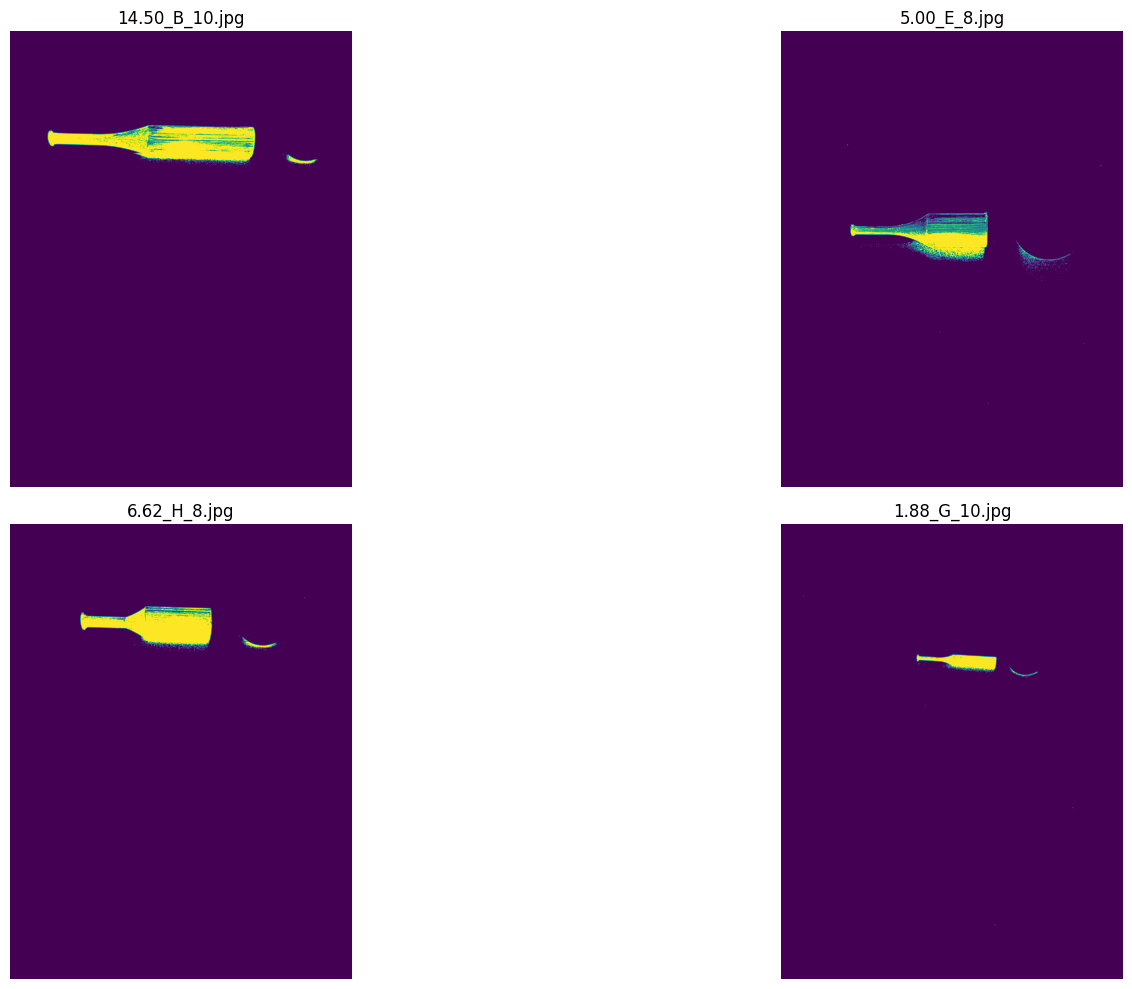

In [3]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt
from google.colab import drive
from skimage import io
from skimage.morphology import skeletonize


import numpy as np
'''
def find_circle_center(p1, p2, p3):
    """
    Find the center of the circle passing through points p1, p2, and p3.
    """
    # Midpoints of lines p1p2 and p2p3
    mid1 = (p1 + p2) / 2
    mid2 = (p2 + p3) / 2

    # Slopes of lines p1p2 and p2p3
    slope1 = (p2[1] - p1[1]) / (p2[0] - p1[0]) if p2[0] != p1[0] else float('inf')
    slope2 = (p3[1] - p2[1]) / (p3[0] - p2[0]) if p3[0] != p2[0] else float('inf')

    # Slopes of the perpendicular bisectors
    perp_slope1 = -1 / slope1 if slope1 != 0 else float('inf')
    perp_slope2 = -1 / slope2 if slope2 != 0 else float('inf')

    # Solving the equations of the lines to find the intersection (center)
    A = np.array([[-perp_slope1, 1], [-perp_slope2, 1]])
    b = np.array([mid1[1] - perp_slope1 * mid1[0], mid2[1] - perp_slope2 * mid2[0]])
    center = np.linalg.solve(A, b)

    return center

def calculate_diameter(p1, p2, p3):
    center = find_circle_center(p1, p2, p3)
    radius = np.linalg.norm(p1 - center)
    diameter = 2 * radius

    return diameter


def get_ratio(image, midpoint, inches = 3):
  ratio = 0
  crop_img = image[:, midpoint + 20:]

  if len(image.shape) == 3:  # Check if the image is color (BGR)
      # Convert to HSV color space
      hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

      # Define range for yellowish color
      lower_yellow = np.array([20, 100, 100])
      upper_yellow = np.array([30, 255, 255])

      # Create mask for yellowish colors
      mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
  else:  # Grayscale image
      mask = image  # No need for color conversion or masking

  left = [0, 0]
  right = [0, 0]
  mid = [0, 0]
  pickedLeft = False
  pickedRandom = False
  counter = 0

  for x in range(mask.shape[1]):

      for y in range(mask.shape[0]):
          if mask[y, x] != 0:  # Yellowish pixel
            right = [y, x]
            counter += 1
            if not pickedLeft:
              left = [y, x]

          # Update the longest line information
          if counter > 100 and not pickedRandom:
              mid = [y, x]
              pickedRandom = True

  p1 = np.array(left)
  p2 = np.array(right)
  p3 = np.array(mid)

  diameter = calculate_diameter(p1, p2, p3)

  ratio = diameter / inches #pixels per inch
  print(p1)
  print(p2)
  print(p3)

  return ratio
'''

import cv2
import numpy as np

def find_circle_diameter(image):
    # Resize for faster processing
    image = cv2.resize(image, (640, 480))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
                               param1=50, param2=30, minRadius=0, maxRadius=0)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, radius = circles[0]
        diameter = 2 * radius
        return diameter
    else:
        return None


def find_columns(image, starting_x, y_coord, y_length):
    if len(image.shape) == 3:  # Check if the image is color (BGR)
        # Convert to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define range for yellowish color
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])

        # Create mask for yellowish colors
        mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    else:  # Grayscale image
        mask = image  # No need for color conversion or masking

    # Initialize variables to track the longest line
    column_lengths = []

    x_coords = range(starting_x - y_length, starting_x)
    # Iterate through each row
    for x in x_coords:
        # Variables to track the current line length
        current_length = 0
        max_length = 0

        # Iterate through each pixel in the row
        for y in range(mask.shape[0]):
            if mask[y, x] != 0:  # Yellowish pixel
                current_length += 1
            else:  # Non-yellowish pixel
                current_length = 0

            # Update the longest line information
            if current_length > max_length:
                max_length = current_length
        column_lengths.append(max_length)

    return column_lengths



def estimate_bat_volume(radii, height):
# The height of each cylindrical slice
    slice_height = height / (len(radii) - 1)

    # Volume of each cylindrical slice
    volumes = [np.pi * (r ** 2) * slice_height for r in radii]

    # Summing up the volumes of all slices
    total_volume = sum(volumes)

    return total_volume

######

def mask(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Invert the grayscale image so the white ball becomes black and vice versa
    inverted_gray_image = cv2.bitwise_not(gray_image)

    # Apply a threshold to get a binary image
    # Here, we're considering the ball to be among the lighter objects in the image
    _, binary_image = cv2.threshold(inverted_gray_image, 200, 255, cv2.THRESH_BINARY)

    img = cv2.GaussianBlur(binary_image, (7, 7), 0)

    return img

def find_longest_yellowish_line(image):
    if len(image.shape) == 3:  # Check if the image is color (BGR)
        # Convert to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define range for yellowish color
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])

        # Create mask for yellowish colors
        mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    else:  # Grayscale image
        mask = image  # No need for color conversion or masking

    # Initialize variables to track the longest line
    max_length = 0
    max_line_y = 0
    max_line_x = 0

    # Iterate through each row
    for y in range(mask.shape[0]):
        # Variables to track the current line length
        current_length = 0

        # Iterate through each pixel in the row
        for x in range(mask.shape[1]):
            if mask[y, x] != 0:  # Yellowish pixel
                current_length += 1
            else:  # Non-yellowish pixel
                current_length = 0

            # Update the longest line information
            if current_length > max_length:
                max_length = current_length
                max_line_y = y
                max_line_x = x

    return max_line_x, max_line_y, max_length

# Calculate the volume of a baseball bat based on pixel radii
def calculate_bat_volume(radii, pixel_to_inch):
    # Convert radii from pixels to inches
    radii_in_inches = [r * pixel_to_inch for r in radii]

    # Assuming each row corresponds to one pixel, and thus the thickness of each disc is 0.01 inch
    delta_y = pixel_to_inch

    # Calculate volume of each disc and sum them up
    volume = sum([np.pi * (r ** 2) * delta_y for r in radii_in_inches])

    return volume

# Function to color below the detected yellowish line
def color_below_line(image, y_line):
    image_below_line = image.copy()
    # Color all pixels below the y_line coordinate with pure red color
    image_below_line[:y_line,:,] = [255, 0, 0]
    return image_below_line

# Mount Google Drive
drive.mount('/content/drive')

# Path to your image directory
directory_path = '/content/drive/My Drive/CVbat'  # Directory containing your images

# List all .jpg files in the directory
all_images = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]
random.shuffle(all_images)
# Randomly select 4 images
#selected_images = random.sample(all_images, min(4, len(all_images)))

model_preds = []
reals = []


# Process and display each of the selected images
plt.figure(figsize=(100, 50))  # Adjust the size as needed
for i, img_name in enumerate(all_images):
    image_path = os.path.join(directory_path, img_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Process the image
    processed_image = mask(image_rgb)

    # Find the longest yellowish line
    endpoint, longest_line_y, longest_line_length = find_longest_yellowish_line(processed_image)
    columns = find_columns(processed_image, endpoint, longest_line_y, longest_line_length)

    diameter = find_circle_diameter(image)
    print(f"The diameter of the circle is: {diameter} pixels")

    if diameter is None:
      ratio = ratio #Use last ratio
    else:
      ratio = 3.0 / diameter

    volume = calculate_bat_volume(columns, ratio)

    plt.subplot(2, 2, i+1)  # Adjust subplot dimensions based on the number of images
    plt.imshow(processed_image)
    print(f"File: {img_name}")
    print(f"Volume: {volume}")
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The diameter of the circle is: 198 pixels
Volume: 1230.1340094538216
The diameter of the circle is: 560 pixels
Volume: 33.860435081786754
The diameter of the circle is: None pixels
Volume: 54.32895529286548
The diameter of the circle is: 694 pixels
Volume: 3.0704284975131255


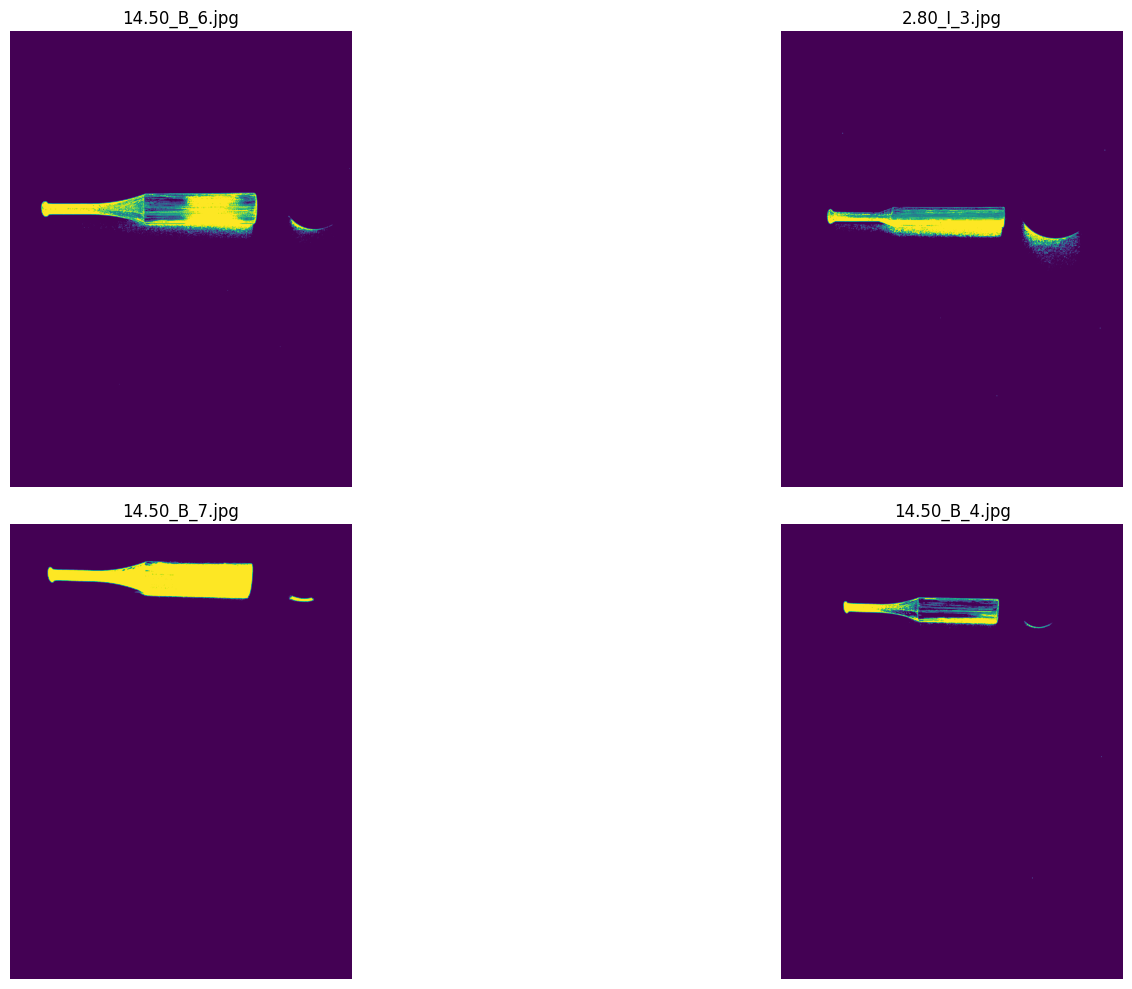

-
0
25.0
-
The diameter of the circle is: 92 pixels
Volume: 562.225148295968
The diameter of the circle is: 182 pixels
Volume: 456.7814923702657
The diameter of the circle is: 270 pixels
Volume: 198.49437812186542
The diameter of the circle is: 76 pixels
Volume: 3496.4461127368645


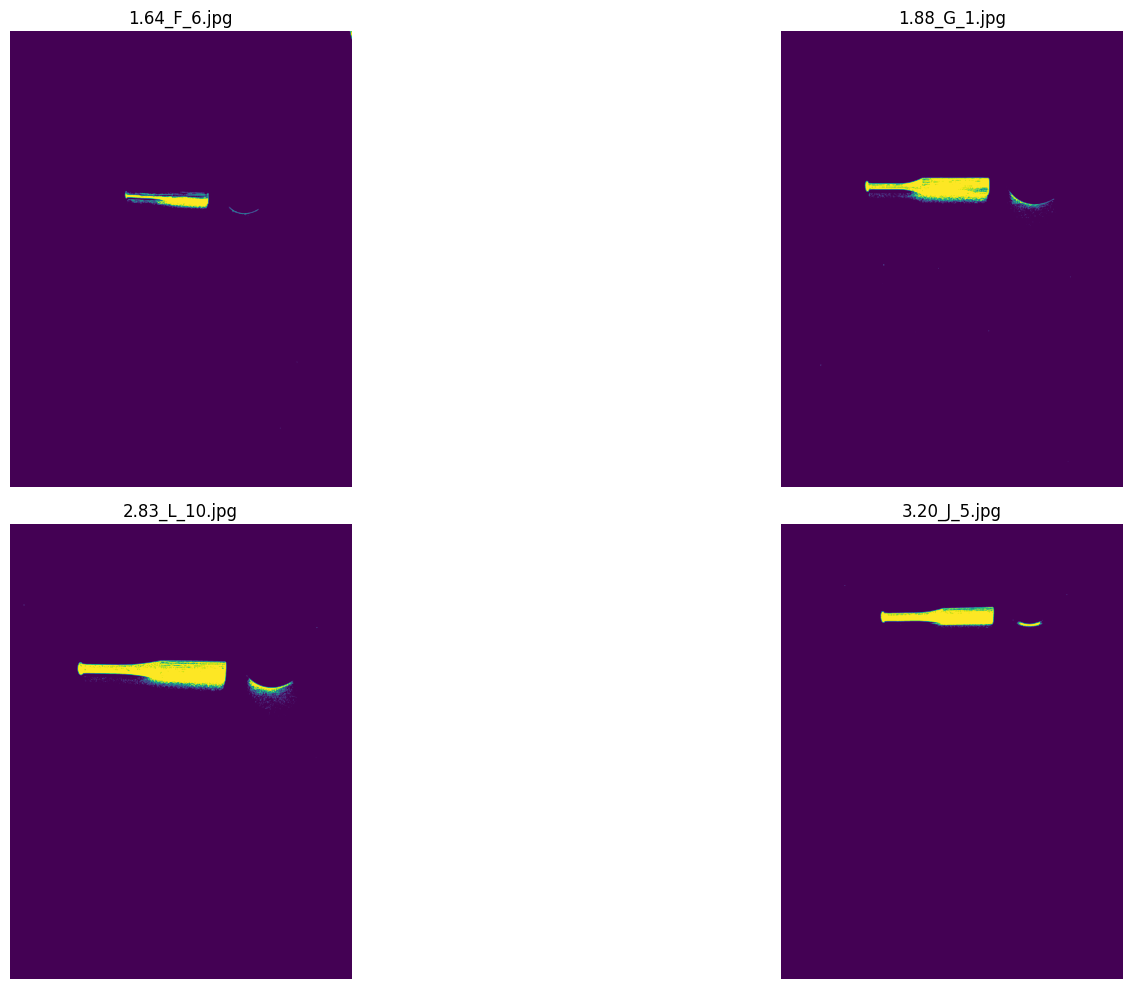

-
4
50.0
-
Overall ordering accuracy: 37.5%


In [15]:
# Function to extract actual volume from filename
def extract_volume_from_filename(filename):
    return float(filename.split('_')[0])

# Function to process images and calculate volumes
def process_images(image_batch):
    ratio = 1
    volumes_calculated = []
    volumes_actual = []
    plt.figure(figsize=(20, 10))
    for i, img_name in enumerate(image_batch):
        image_path = os.path.join(directory_path, img_name)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
##
        processed_image = mask(image_rgb)

        # Find the longest yellowish line
        endpoint, longest_line_y, longest_line_length = find_longest_yellowish_line(processed_image)
        columns = find_columns(processed_image, endpoint, longest_line_y, longest_line_length)

        diameter = find_circle_diameter(image)
        print(f"The diameter of the circle is: {diameter} pixels")

        if diameter is None:
            ratio = ratio
        else:
          ratio = 3.0 / diameter

        volume = calculate_bat_volume(columns, ratio)
        print(f"Volume: {volume}")
##
        actual_volume = extract_volume_from_filename(img_name)

        plt.subplot(2, 2, i+1)
        plt.imshow(processed_image)
        plt.title(img_name)
        plt.axis('off')

        volumes_calculated.append(volume)
        volumes_actual.append(actual_volume)

    plt.tight_layout()
    plt.show()
    return volumes_calculated, volumes_actual

# Function to calculate accuracy of volume ordering
def calculate_ordering_accuracy(volumes_calculated, volumes_actual):
    sorted_calculated = np.argsort(volumes_calculated)
    sorted_actual = np.argsort(volumes_actual)
    correct_orderings = sum(sorted_calculated == sorted_actual)
    accuracy = (correct_orderings / len(volumes_calculated)) * 100
    return accuracy



# Mount Google Drive
drive.mount('/content/drive')

# Path to your image directory
directory_path = '/content/drive/My Drive/CVbat'  # Directory containing your images

# List all .jpg files in the directory
all_images = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]
random.shuffle(all_images)

# Main loop to process all images in batches of 4
total_accuracy = []
for i in range(0, 8, 4):
    image_batch = all_images[i:i+4]
    volumes_calculated, volumes_actual = process_images(image_batch)
    accuracy = calculate_ordering_accuracy(volumes_calculated, volumes_actual)
    print("-")
    print(i)
    print(accuracy)
    print("-")
    total_accuracy.append(accuracy)

# Calculate overall accuracy
overall_accuracy = sum(total_accuracy) / len(total_accuracy)
print(f"Overall ordering accuracy: {overall_accuracy}%")


